<a href="https://colab.research.google.com/github/labibaa/shongkhepon/blob/main/499B_keyframeExtractedLVersion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import tensorflow as tf
import keras

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import sys
from keras.preprocessing import image
from skimage.transform import resize
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import os
from PIL import Image
%matplotlib inline

In [ ]:
!pip install python-docx

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import docx
from docx import Document
from docx.shared import Inches
from docx.enum.text import WD_BREAK

In [ ]:
from keras.applications import ResNet50

In [ ]:
videoPath = "/content/drive/MyDrive/cse498r/mrbean.mp4"

In [ ]:
#Function to read all the frames from a given video
def read_frames(video_path):
  frameList = []
  cap = cv2.VideoCapture(videoPath)
  while(True):
    ret,frame = cap.read()
    if ret:
      frameList.append(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    else:
      break

  return frameList

#function to calculate timestamp of each frame
def get_timestamp(videoPath):
  cap = cv2.VideoCapture(videoPath)
  fps = cap.get(cv2.CAP_PROP_FPS)

  timestamps = [cap.get(cv2.CAP_PROP_POS_MSEC)]
  calcTimestamps = [0.0]

  while(cap.isOpened()):
    ret, frame = cap.read()
    if ret:
      timestamps.append(cap.get(cv2.CAP_PROP_POS_MSEC))
      calcTimestamps.append((calcTimestamps[-1] + 1000/fps))
    else:
        break

  cap.release()
  return calcTimestamps,fps
def fps(videoPath):
  cap = cv2.VideoCapture(videoPath)
  fps = cap.get(cv2.CAP_PROP_FPS)
  return fps

#Function to resize the frame to (224,224,3)
def resize_frame(frameList):
  X = []
  for frame in frameList:
    a = resize(frame,preserve_range=True,output_shape=(224,224)).astype(int)
    X.append(a)
  return X

In [ ]:
# calcTimestamps = get_timestamp(videoPath)
# frameList = read_frames(videoPath)
fpsv= fps(videoPath)
print(fpsv)

30.0


In [ ]:
totalFrames = len(frameList)
print(len(frameList))
print(frameList[1].shape)

2178
(720, 1280, 3)


In [ ]:
X = resize_frame(frameList)

<class 'list'>
(224, 224, 3)


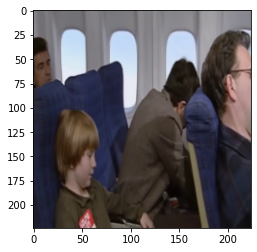

In [ ]:
print(type(X))
print(X[0].shape)
plt.rcParams["axes.grid"] = False
plt.imshow(X[1000])

In [ ]:
X = np.array(X)
#X = preprocess_input(X,data_format=None)
#create a base model
base_model = ResNet50(include_top=False,weights='imagenet',
                      input_shape=(224,224,3),
                      pooling='avg')

#extract image embeddings from pre-trained model
X = base_model.predict(X)

69/69 [==============================] - 351s 5s/step


In [ ]:
X.shape
#X = X.reshape((-1,7*7*512))

(2178, 2048)

In [ ]:
pca = PCA(n_components=128,
         random_state = 234,
         svd_solver = 'auto')
X_pca = pca.fit_transform(X)

In [ ]:
X_pca.shape

(2178, 128)

In [ ]:
cost = []
for i in range(10,100):
  KM  =  KMeans(n_clusters=i,max_iter = 500)
  KM.fit(X_pca)
  cost.append(KM.inertia_)

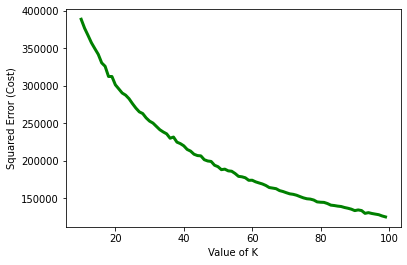

In [ ]:
plt.plot(range(10,100),cost,color='g',linewidth='3')
plt.yscale('linear')
plt.xlabel("Value of K")
plt.ylabel("Squared Error (Cost)")
plt.show()

In [ ]:
n_clusters = 80
score = 1500000

In [ ]:
KM = KMeans(n_clusters=n_clusters,max_iter=500)
KM.fit(X_pca)
cost.append(KM.inertia_)
cluster_centers = KM.cluster_centers_
labels = KM.labels_

In [ ]:
print(type(cluster_centers))
print(cluster_centers.shape)
print(type(labels))
print(labels.shape)

<class 'numpy.ndarray'>
(80, 128)
<class 'numpy.ndarray'>
(2178,)


In [ ]:
dist = []
indices = []
for i in range(n_clusters):
  min_dist = sys.maxsize
  index = -1
  for j in range(totalFrames):
    if(np.sum(np.square(cluster_centers[i,:] - X_pca[j,:])) < min_dist):
      min_dist = np.sum(np.square(cluster_centers[i,:] - X_pca[j,:]))
      index = j
      pass
    pass
  indices.append(index)
  dist.append(min_dist)

In [ ]:
indices[:10]

In [ ]:
key_frames = []
for i in sorted(indices):
  key_frames.append(frameList[i])

print(len(key_frames))

IndexError: ignored

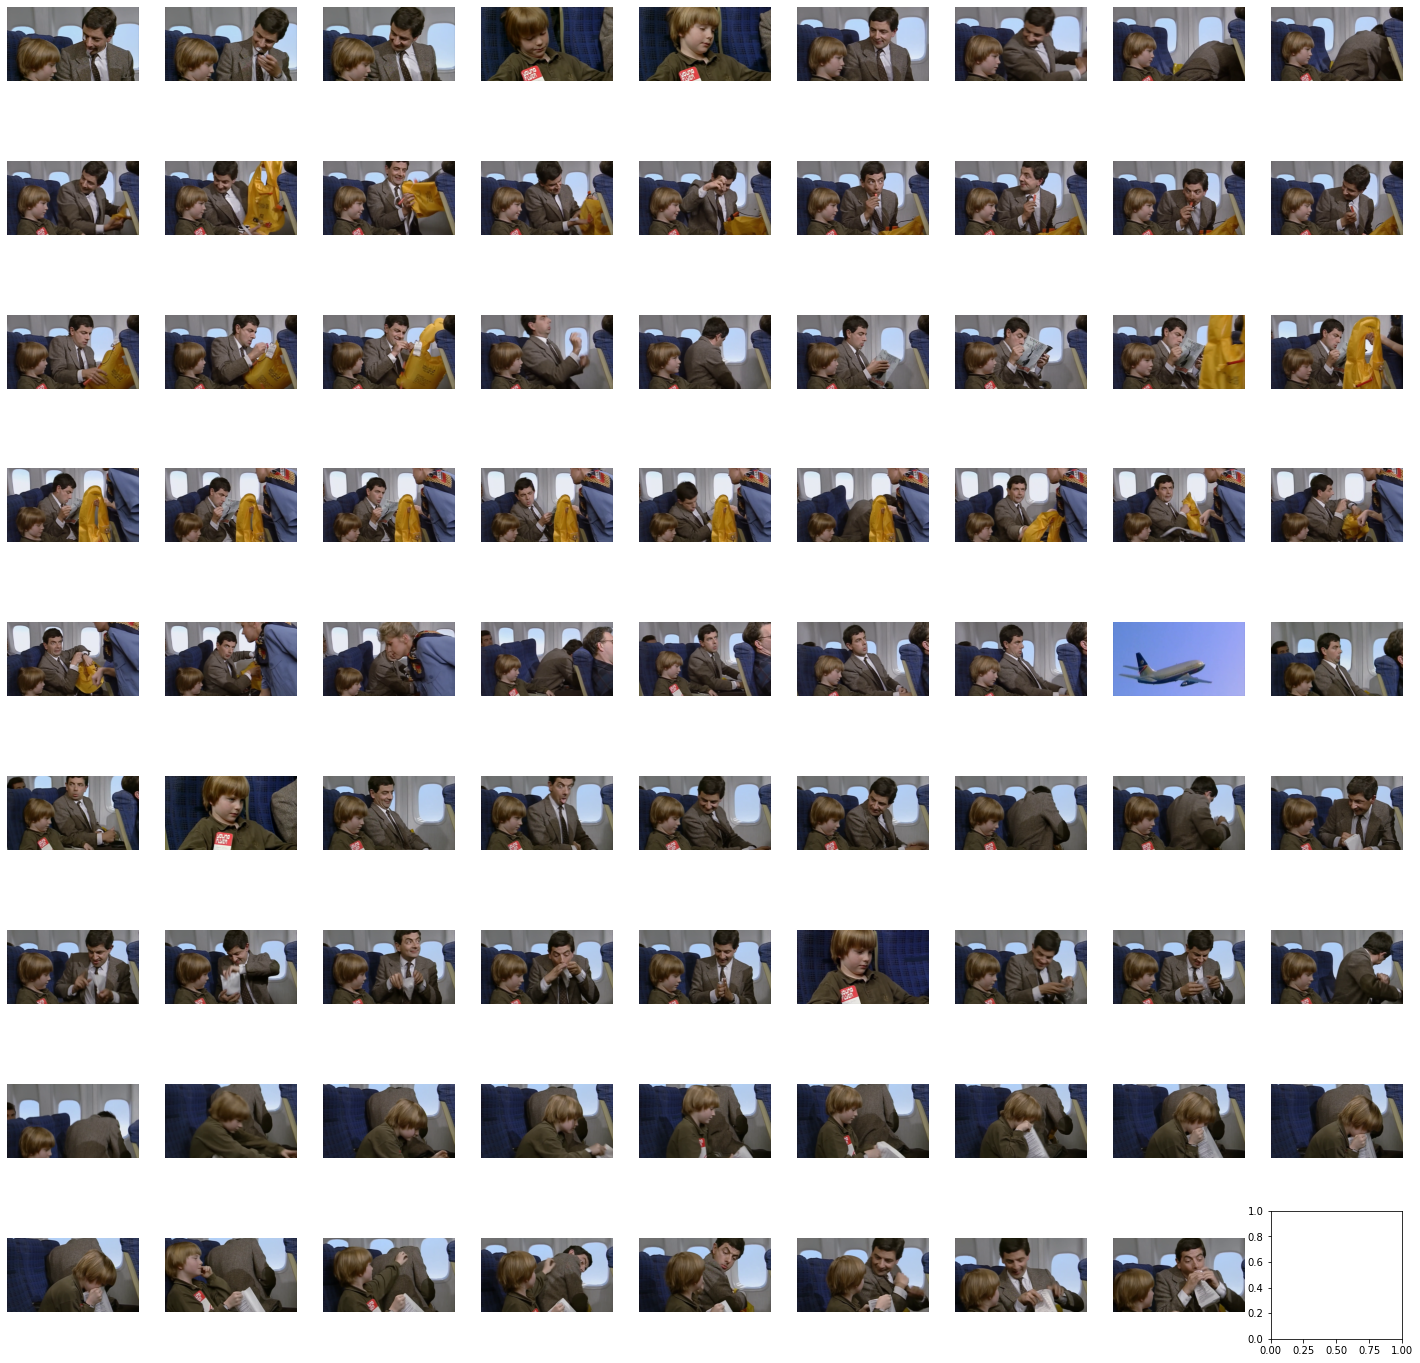

In [ ]:
plt.rcParams["axes.grid"] = False

grid_size = int(np.ceil(np.sqrt(n_clusters)))

f, axarr = plt.subplots(grid_size,grid_size,figsize=(25, 25))
for i in range(grid_size):
  for j in range(grid_size):
    axarr[i,j].imshow(key_frames[grid_size*i + j])
    axarr[i,j].axis('off')

In [ ]:
def get_data(filename):
    document = Document(filename)
    fullText = []
    for para in document.paragraphs:
        fullText.append(para.text)
    document.save(filename)
    return '\n'.join(fullText)


def add_frame_time(document,indices,calcTimestamps):
  p = document.add_paragraph()
  r = p.add_run()
  for index in indices:
    frameMin =(calcTimestamps[index]/(1000*60))%60
    frameMin = round(frameMin,2)
    r.add_text("Time = ")
    r.add_text(str(frameMin))
    r.add_text(' ')
    pass
def add_frame_number(document,textList):
  p = document.add_paragraph()
  r = p.add_run()
  for text in textList:
    r.add_text("Frame No. : ")
    r.add_text(str(text))
    r.add_text(' ')
    pass

def add_initial_data(document,videoName,time,totalKeyFrames,score):
  p = document.add_paragraph()
  r = p.add_run()
  r.add_text(videoName)
  r.add_text(',')
  r.add_text('Video Processing Time = ' + str(time))
  r.add_text(',')
  r.add_text('Key Frames Extracted = ' + str(totalKeyFrames))
  r.add_text(',')
  r.add_text('Evaluation Metric = Inertia')
  r.add_text(',')
  r.add_text('Metric Score = '+str(score))

def add_pic(document,frameList):
  size = (80,80)
  p = document.add_paragraph()
  r = p.add_run()
  for frame in frameList:
    im = Image.fromarray(frame)
    im.thumbnail(size)
    name = 'image' + str(i) + '.png'
    im.save(name)
    r.add_picture(name)
    r.add_text(' ')

def add_data(fileName,key_frames,videoName,score,indices,calcTimestamps,totalFrames,document):
  size = (80,80)
  p = document.add_paragraph()
  r = p.add_run()
  time = (calcTimestamps[totalFrames]/(1000*60))%60
  time = round(time,2)
  indices = sorted(indices)
  totalKeyFrames = len(key_frames)
  add_initial_data(document,videoName,time,totalKeyFrames,score)
  r.add_break(WD_BREAK.LINE)
  num = totalKeyFrames // 5
  rem = totalKeyFrames - num
  for i in range(num):
    add_frame_number(document,indices[i*5:i*5+5])
    r.add_break(WD_BREAK.LINE)
    add_frame_time(document,indices[i*5:i*5+5],calcTimestamps)
    r.add_break(WD_BREAK.LINE)
    add_pic(document,key_frames[i*5:i*5+5])
    r.add_break(WD_BREAK.LINE)
    pass
  add_frame_number(document,indices[num*5:])
  r.add_break(WD_BREAK.LINE)
  add_frame_time(document,indices[num*5:],calcTimestamps)
  r.add_break(WD_BREAK.LINE)
  add_pic(document,key_frames[num*5:])
  r.add_break(WD_BREAK.LINE)
  document.save('test.docx')

def generateTestFile(fileName,key_frames,videoName,score,indices,calcTimestamps,totalFrames):
  if os.path.isfile(fileName):
    data = get_data(fileName)
    document = Document(fileName)
    p = document.add_paragraph()
    r = p.add_run()
    r.add_text(data)
    add_data(fileName,key_frames,videoName,score,indices,calcTimestamps,totalFrames,document)
  else:
    document = Document()
    add_data(fileName,key_frames,videoName,score,indices,calcTimestamps,totalFrames,document)


In [ ]:
videoName = 'Summarized_Video1'
generateTestFile('test.docx',key_frames,videoName,score,indices,calcTimestamps,totalFrames)


In [ ]:
from google.colab import files
files.download('test.docx')

In [ ]:
key_frames[50]

In [ ]:
from PIL import Image
key_img=[]
for i in enumerate(key_frames):
    img=Image.fromarray(key_frames[0])
    key_img.append(img)

In [ ]:
len(key_img)

In [ ]:
key_img[8]

In [ ]:
width,height=key_img[0].width,key_img[0].height
size=(width,height)
print(size)

In [ ]:
import cv2

In [ ]:
out= cv2.VideoWriter('Summarized_video.avi',cv2.VideoWriter_fourcc(*'DIVX'),8,size)
for i in range(len(key_frames)):
  out.write(key_frames[i])
out.release()


In [ ]:
from google.colab import files
files.download('Summarized_video.avi')